In [1]:
import re
from nltk.corpus import stopwords
from sparknlp.annotator import StopWordsCleaner
import pandas as pd

## Read in the data:

In [65]:
df = pd.read_csv("CS_Papers.csv")

## Perform initial preprocessing:

In [66]:
df['processed'] = df['Abstract'].map(lambda x: re.sub('[,\.!?]', '', x))
df['processed'] = df['processed'].map(lambda x: x.lower())
df['processed'].head()

<>:1: DeprecationWarning: invalid escape sequence \.
<>:1: DeprecationWarning: invalid escape sequence \.
C:\Users\rylan\AppData\Local\Temp\ipykernel_18124\4148200583.py:1: DeprecationWarning: invalid escape sequence \.
  df['processed'] = df['Abstract'].map(lambda x: re.sub('[,\.!?]', '', x))


0    this paper presents a comprehensive workflow t...
1    this paper presents ido a compiler-directed ap...
2    this paper presents elastin a stagnation-free ...
3    this paper presents benchprime an automated be...
4    we present a composable workflow to enable hig...
Name: processed, dtype: object

### Import nltk for stopword removal:

In [67]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

### Import Gensim libraries: 

In [68]:
import gensim
from gensim.utils import simple_preprocess
from pprint import pprint

In [69]:
# Convert to list 
data = df.processed.values.tolist()  
# Remove Emails 
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]  
# Remove new line characters 
data = [re.sub('\s+', ' ', sent) for sent in data]  
# Remove distracting single quotes 
data = [re.sub("\'", "", sent) for sent in data]  

pprint(data[:1])

['this paper presents a comprehensive workflow to address two major factors in '
 'multivariate multidimensional (mvmd) scientific visualization: the '
 'scalability of rendering and the scalability of representation (for '
 'perception) our workflow integrates the metrics of scientific computing and '
 'visualization across di fferent stem domains to deliver perceivable '
 'visualizations that meet scientists’ expectations our approach attempts to '
 'balance the performance of mvmd visualizations using techniques such as '
 'sub-sampling domain decomposition and parallel rendering when mapping data '
 'to visual form we considered: the nature of the data (dimensionality type '
 'and distribution) the computing power (serial or parallel) and the rendering '
 'power (rendering mechanism format and display spectrum) we used hpc clusters '
 'to perform remote parallel processing and visualization of large-scale data '
 'sets such as 3d point clouds galaxy catalogs and airflow simulations

<>:4: DeprecationWarning: invalid escape sequence \S
<>:6: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \S
<>:6: DeprecationWarning: invalid escape sequence \s
C:\Users\rylan\AppData\Local\Temp\ipykernel_18124\1601974967.py:4: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
C:\Users\rylan\AppData\Local\Temp\ipykernel_18124\1601974967.py:6: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


In [70]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
data_words = list(sent_to_words(data))

print(data_words[:1])

[['this', 'paper', 'presents', 'comprehensive', 'workflow', 'to', 'address', 'two', 'major', 'factors', 'in', 'multivariate', 'mvmd', 'scientific', 'visualization', 'the', 'scalability', 'of', 'rendering', 'and', 'the', 'scalability', 'of', 'representation', 'for', 'perception', 'our', 'workflow', 'integrates', 'the', 'metrics', 'of', 'scientific', 'computing', 'and', 'visualization', 'across', 'di', 'fferent', 'stem', 'domains', 'to', 'deliver', 'perceivable', 'visualizations', 'that', 'meet', 'scientists', 'expectations', 'our', 'approach', 'attempts', 'to', 'balance', 'the', 'performance', 'of', 'mvmd', 'visualizations', 'using', 'techniques', 'such', 'as', 'sub', 'sampling', 'domain', 'decomposition', 'and', 'parallel', 'rendering', 'when', 'mapping', 'data', 'to', 'visual', 'form', 'we', 'considered', 'the', 'nature', 'of', 'the', 'data', 'dimensionality', 'type', 'and', 'distribution', 'the', 'computing', 'power', 'serial', 'or', 'parallel', 'and', 'the', 'rendering', 'power', 'r

In [71]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=50)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['this_paper_presents', 'comprehensive', 'workflow', 'to', 'address', 'two_major', 'factors', 'in', 'multivariate', 'mvmd', 'scientific', 'visualization', 'the', 'scalability', 'of', 'rendering', 'and', 'the', 'scalability', 'of', 'representation', 'for', 'perception', 'our', 'workflow', 'integrates', 'the', 'metrics', 'of', 'scientific', 'computing', 'and', 'visualization', 'across', 'di', 'fferent', 'stem', 'domains', 'to', 'deliver', 'perceivable', 'visualizations', 'that', 'meet', 'scientists', 'expectations', 'our_approach', 'attempts_to', 'balance', 'the', 'performance', 'of', 'mvmd', 'visualizations', 'using', 'techniques', 'such_as', 'sub', 'sampling', 'domain', 'decomposition', 'and', 'parallel', 'rendering', 'when', 'mapping', 'data', 'to', 'visual', 'form', 'we', 'considered', 'the', 'nature', 'of', 'the', 'data', 'dimensionality', 'type', 'and', 'distribution', 'the', 'computing', 'power', 'serial', 'or', 'parallel', 'and', 'the', 'rendering', 'power', 'rendering', 'mechani

In [72]:
# Define function for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [73]:
import spacy
nlp = spacy.load("en_core_web_trf")

In [74]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_trf", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

C:\Users\rylan\anaconda3\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


[['comprehensive', 'workflow', 'address', 'two_major', 'factor', 'multivariate', 'mvmd', 'scientific', 'visualization', 'scalability', 'rendering', 'scalability', 'representation', 'perception', 'workflow', 'integrate', 'metric', 'scientific', 'computing', 'visualization', 'fferent', 'stem', 'domain', 'deliver', 'perceivable', 'visualization', 'meet', 'scientist', 'expectation', 'approach', 'attempt', 'balance', 'performance', 'visualization', 'use', 'technique', 'sub', 'sampling', 'domain', 'decomposition', 'parallel', 'rendering', 'mapping', 'datum', 'visual', 'form', 'consider', 'nature', 'datum', 'dimensionality', 'type', 'distribution', 'computing', 'power', 'serial', 'parallel', 'rendering', 'power', 'rendering', 'mechanism', 'format', 'display', 'spectrum', 'use', 'cluster', 'perform', 'remote', 'parallel', 'processing', 'visualization', 'large_scale', 'data_set', 'point', 'cloud', 'galaxy', 'catalog', 'airflow', 'simulation', 'workflow', 'bring', 'consideration', 'structured', 

### More imports:

In [75]:
import re
import numpy as np
import pandas as  pd
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

In [76]:
# Create Dictionary 
id2word = corpora.Dictionary(data_lemmatized)  
# Create Corpus 
texts = data_lemmatized  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 2), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 3), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2), (49, 1), (50, 1), (51, 4), (52, 1), (53, 1), (54, 2), (55, 2), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (68, 6), (69, 3)]]


### Create the LDA model:

In [39]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12, 
                                           random_state=100, 
                                           update_every=1,
                                           chunksize=100,
                                           passes=100,
                                           alpha='auto',
                                           per_word_topics=True)

In [132]:
model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12, 
                                           update_every=1,
                                           chunksize=100,
                                           passes=120,
                                           alpha='auto',
                                           per_word_topics=True)

### LDA model evaluation:

In [78]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.174301827166985

Coherence Score:  0.3476704288947016


### Visualize Results:

In [179]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, R = 10)

vis

C:\Users\rylan\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.299776  0.074152       1        1  38.352761
1      0.216360 -0.289814       2        1  14.038367
0      0.130343  0.247371       3        1  10.706759
7      0.144875 -0.040578       4        1  10.101055
3     -0.101925 -0.095720       5        1   4.973515
6     -0.135825 -0.061646       6        1   4.967421
8     -0.013986  0.103976       7        1   4.100374
2     -0.101880  0.051097       8        1   3.694752
11    -0.075213  0.098746       9        1   3.163441
9     -0.098811 -0.044927      10        1   2.911814
5     -0.133764 -0.022557      11        1   2.154114
10    -0.129949 -0.020099      12        1   0.835626, topic_info=           Term        Freq       Total Category  logprob  loglift
178   algorithm  494.000000  494.000000  Default  10.0000  10.0000
416     problem  582.000000  582.000000  Default   9.0000   9.0000
169      system  842.000000  842.000000  Default   8.0000   8.0000
550     process  271.000000  271.000000  Default   7.0000   7.0000
309       model  579.000000  579.000000  Default   6.0000   6.0000
...         ...         ...         ...      ...      ...      ...
2052       plan    7.431365    8.259275  Topic12  -4.3460   4.6791
2139    circuit    6.822025    7.649915  Topic12  -4.4315   4.6702
2038     growth    6.595570    7.423482  Topic12  -4.4653   4.6665
2045      agent    6.467114    7.295020  Topic12  -4.4850   4.6643
1422  retrieval    8.152004   34.327544  Topic12  -4.2534   3.3471

[192 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
730       3  0.234618     access
730       5  0.759715     access
531       4  0.975379   accuracy
2045     12  0.822479      agent
178       2  0.998987  algorithm
...     ...       ...        ...
1889     10  0.965673    usually
1045      2  0.996125   variable
1332     11  0.989080        web
957       1  0.993061       work
879       6  0.982041       year

[252 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 8, 4, 7, 9, 3, 12, 10, 6, 11])

### (Optional) Save the model to disk:

In [96]:
from gensim.test.utils import datapath

temp_file = datapath("gensim_lda_model")

lda_model.save(temp_file)

In [5]:
# from gensim.test.utils import datapath

# temp_file = datapath("gensim_lda_model")
# lda_model = gensim.models.ldamodel.LdaModel.load(temp_file)

## Evaluation of models:

#### Scores for 10 Topics:

In [ ]:
coherence_10 = []
perplex_10 = []

for i in range(10):
    
    model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    cur_perp = model.log_perplexity(corpus)
    perplex_10.append(cur_perp)
    
    coherence_model_lda = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_10.append(coherence_lda)

#### Scores for 12 Topics:

In [36]:
coherence_12 = []
perplex_12 = []

for i in range(10):
    
    model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12, 
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    cur_perp = model.log_perplexity(corpus)
    perplex_12.append(cur_perp)
    
    coherence_model_lda = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_12.append(coherence_lda)

#### Scores for 14 Topics:

In [ ]:
coherence_14 = []
perplex_14 = []

for i in range(10):
    
    model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    cur_perp = model.log_perplexity(corpus)
    perplex_14.append(cur_perp)
    
    coherence_model_lda = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_14.append(coherence_lda)

#### Scores for 16 Topics:

In [43]:
coherence_16 = []
perplex_16 = []

for i in range(10):
    
    model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=16, 
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    cur_perp = model.log_perplexity(corpus)
    perplex_16.append(cur_perp)
    
    coherence_model_lda = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_16.append(coherence_lda)

### Make boxplot:

In [50]:
coherence_scores = [coherence_10, coherence_12, coherence_14, coherence_16]
perplexity_scores = [perplex_10, perplex_12, perplex_14, perplex_16]

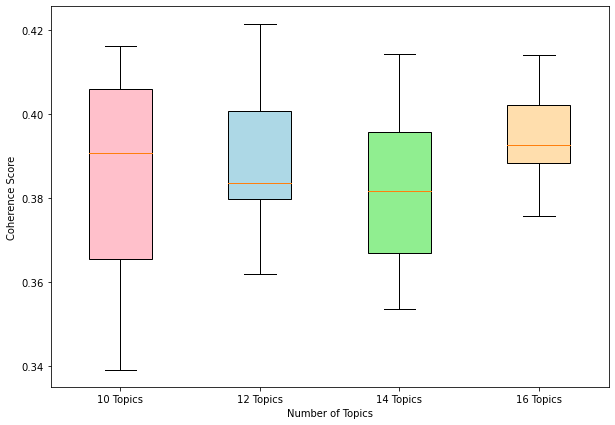

In [73]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

bplot = plt.boxplot(coherence_scores, patch_artist = True)

ax.set_xticklabels(['10 Topics', '12 Topics', '14 Topics', '16 Topics'])
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")

colors = ['pink', 'lightblue', 'lightgreen', 'navajowhite']
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        
plt.savefig("Coherence_Boxplot")

### Make lineplot for Perplexity:

In [60]:
perplex_means = []
for topic in perplexity_scores:
    perplex_means.append(np.mean(topic))

perplex_means

[-7.860003123661334,
 -8.376989087004485,
 -9.689944177497711,
 -10.57416914101568]

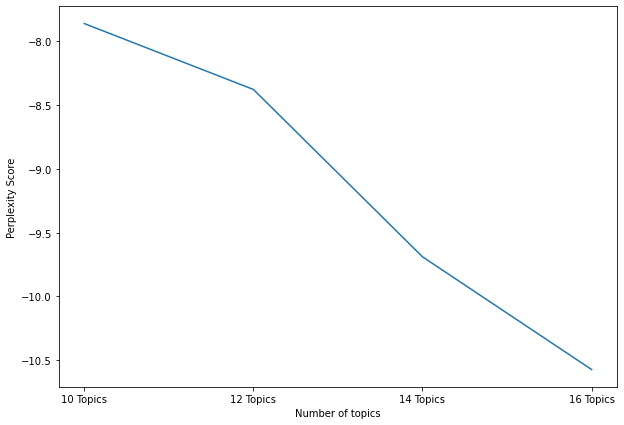

In [74]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

plt.plot(perplex_means)
plt.xticks([0, 1, 2, 3])
ax.set_xticklabels(['10 Topics', '12 Topics', '14 Topics', '16 Topics'])
plt.ylabel("Perplexity Score")
plt.xlabel("Number of topics")

plt.savefig("Perplexity_Plot")

## Getting topic distribution for a document:

In [188]:
max(lda_model.get_document_topics(corpus[42]), key = lambda x: x[1])[0]

11

In [137]:
topic_results = lda_model.show_topics(formatted = False, num_topics = 12)
topic_results

[(0,
  [('system', 0.028370176),
   ('user', 0.02736499),
   ('development', 0.024560051),
   ('model', 0.022978337),
   ('describe', 0.016686473),
   ('tool', 0.015607379),
   ('report', 0.014536361),
   ('provide', 0.014232572),
   ('database', 0.012321226),
   ('environment', 0.011938769)]),
 (1,
  [('algorithm', 0.051245924),
   ('problem', 0.04954462),
   ('method', 0.023054011),
   ('solution', 0.019613799),
   ('set', 0.018484524),
   ('function', 0.0150032425),
   ('solve', 0.013402159),
   ('optimization', 0.011702586),
   ('point', 0.011518716),
   ('give', 0.011258032)]),
 (2,
  [('process', 0.056272235),
   ('requirement', 0.03403831),
   ('phase', 0.025657518),
   ('methodology', 0.025409654),
   ('reuse', 0.02508511),
   ('maintenance', 0.019621022),
   ('testing', 0.016677668),
   ('product', 0.013295751),
   ('software', 0.013214421),
   ('relate', 0.011801784)]),
 (3,
  [('information', 0.051892437),
   ('network', 0.032458372),
   ('document', 0.027720198),
   ('graph

In [177]:
print(df.iloc[42].Abstract)

Most common object models of distributed object systems lack support for 'polymorphism' (an abstraction mechanism that represents a quality or state of being able to assume different forms).  This lack of support restricts the development of new components and limits reuse of existing components that use these advanced features.  In this paper, the Interoperable Common Object Model (ICOM), which focuses on a subset of object-oriented languages, specifically statically typed languages, is presented.  The ICOM model is an attempt to elevate common object models closer to the object models of statically typed object-oriented languages by including support for polymorphism.  Specific features of the ICOM object model include: remote inheritance, method overloading, and parameterized types.


### Create DF of results to match spark output:

In [178]:
result_df_diff = pd.DataFrame(columns = ["topic", "topicwords"])

for t in topic_results:
    curr = []
    for top in range(10):
        curr.append(t[1][top][0])
        
    new_row = {"topic": t[0], "topicwords": curr}
    result_df_diff = result_df_diff.append(new_row, ignore_index = True)
result_df_diff

C:\Users\rylan\AppData\Local\Temp\ipykernel_18124\3555954314.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_diff = result_df_diff.append(new_row, ignore_index = True)
C:\Users\rylan\AppData\Local\Temp\ipykernel_18124\3555954314.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_diff = result_df_diff.append(new_row, ignore_index = True)
C:\Users\rylan\AppData\Local\Temp\ipykernel_18124\3555954314.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_diff = result_df_diff.append(new_row, ignore_index = True)
C:\Users\rylan\AppData\Local\Temp\ipykernel_18124\3555954314.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

,topic,topicwords
0,0,"[system, user, development, model, describe, t..."
1,1,"[algorithm, problem, method, solution, set, fu..."
2,2,"[process, requirement, phase, methodology, reu..."
3,3,"[information, network, document, graph, user, ..."
4,4,"[use, system, design, application, approach, b..."
5,5,"[web, display, tree, proxy, learning, rate, pa..."
6,6,"[form, computation, necessary, measure, comple..."
7,7,"[time, space, model, result, representation, s..."
8,8,"[matrix, program, execution, processor, model,..."
9,9,"[equation, image, homotopy, load, probability_..."


### Create DF of results matching PyLDAVis topic ordering:

In [180]:
top_topics = lda_model.top_topics(corpus, topn = 10)

In [182]:
results_df = pd.DataFrame(columns = ["topic", "topicwords"])

i = 0
for t in top_topics:
    curr = []
    for top in range(10):
        curr.append(t[0][top][1])
        
    new_row = {"topic": i, "topicwords": curr}
    results_df = results_df.append(new_row, ignore_index = True)
    i += 1

C:\Users\rylan\AppData\Local\Temp\ipykernel_18124\2920603485.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index = True)
C:\Users\rylan\AppData\Local\Temp\ipykernel_18124\2920603485.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index = True)
C:\Users\rylan\AppData\Local\Temp\ipykernel_18124\2920603485.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index = True)
C:\Users\rylan\AppData\Local\Temp\ipykernel_18124\2920603485.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resul

### Save result df to print in collab (Simply for formatting purposes)

In [125]:
result_df_diff.to_csv("Gensim_model_df_dist.csv", index = False)

In [185]:
results_df.to_csv("Gensim_model_results.csv", index = False)

### Topic Frequency:

In [189]:
dominant_topic_list = []
for doc in range(len(corpus)):
    dominant_topic = max(lda_model.get_document_topics(corpus[doc]), key = lambda x: x[1])[0]
    dominant_topic_list.append(dominant_topic)

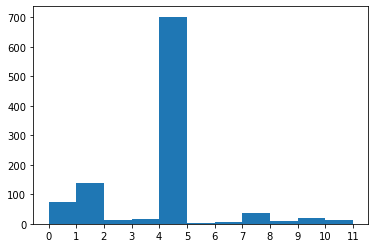

In [195]:
plt.hist(dominant_topic_list, bins=range(12))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
plt.show()